<a href="https://colab.research.google.com/github/ra4ola/APA-Assigment2/blob/main/Parte%201/Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [44]:
from torch.nn.modules.flatten import Flatten
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from google.colab import drive
import torch.nn.functional as F

# Mount Drive

In [24]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definição de Variáveis

In [25]:
PATH = '/content/drive/MyDrive/APA/Assigment2/Parte3'

In [26]:
image_size = 28
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Modelos


In [43]:
# @title AE

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder_conv = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        self.decoder_conv = nn.Sequential(

         nn.ConvTranspose2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(128),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(64),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(32),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(8),
         nn.ELU(),

         nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample
         nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(1),
         nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.decoder_conv(x)
        return x

In [28]:
# @title VAE
class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()
      self.encoder_conv = nn.Sequential(
          nn.Conv2d(1, 8, 3, 2, 1),
          nn.BatchNorm2d(8),
          nn.ELU(inplace=True),

          nn.Conv2d(8, 32, 3, 1, 1),
          nn.BatchNorm2d(32),
          nn.ELU(inplace=True),

          nn.Conv2d(32, 64, 3, 1, 1),
          nn.BatchNorm2d(64),
          nn.ELU(inplace=True),

          nn.Conv2d(64, 128, 3, 1, 1),
          nn.BatchNorm2d(128),
          nn.ELU(inplace=True),
        )

      self.mean_layer = nn.Linear(128 * (image_size // 2) ** 2, 16)

      self.logvar_layer = nn.Linear(128 * (image_size // 2) ** 2, 16)

      self.decoder_conv = nn.Sequential(

          nn.ConvTranspose2d(16, 128, 3, 1, 1),
          nn.BatchNorm2d(128),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(128, 64, 3, 1, 1),
          nn.BatchNorm2d(64),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(64, 32, 3, 1, 1),
          nn.BatchNorm2d(32),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(32, 8, 3, 1, 1),
          nn.BatchNorm2d(8),
          nn.ELU(inplace=True),

          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.ConvTranspose2d(8, 1, 3, 1, 1),
          nn.BatchNorm2d(1),
          nn.Sigmoid()
        )

    def forward(self, x):
      x = add_noise()
      x = self.encoder_conv(x)
      x = x.view(x.size(0), -1)
      mean, logvar = self.mean_layer(x), self.logvar_layer(x)
      epsilon = torch.randn_like(torch.exp(0.5 * logvar)).to(device)
      x = mean + logvar*epsilon
      x = self.decoder_conv(x.view(x.size(0), 16, (image_size // 2), (image_size // 2)))
      return x, mean, logvar



## DAE

In [45]:
# @title DAE

class DAE(nn.Module):
    def __init__(self):
      super(DAE, self).__init__()
      self.encoder = AE()

    def forward(self, x):
      x = add_noise(x)
      x = self.encoder(x)
      return x

# Definição de Funções

### Funções de Construção das String para os Caminhos

In [32]:
def ModelDirStr(modelName,path = PATH):
  return f"{path}/{modelName}"
def pathModelStr(modelName,epoch, path = PATH):
  return f"{ModelDirStr(modelName,path)}/{modelName}_epoch={epoch}"

### Função para adicionar Noise

In [29]:
# @title Noise Fuction DAE

def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * torch.randn_like(data)
    return torch.clamp(noisy_data, 0., 1.)




### Função de Treino


In [31]:
# @title Train Fuction

def train(model, criterion, optimizer, train_loader, epochs, modelName, scheduler=None, path=PATH):
    os.makedirs(ModelDirStr(modelName=modelName, path=path), exist_ok=True)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()

            if isinstance(model, VAE):
                outputs, mean, log_var = model(inputs)
                reconstruction_loss = criterion(outputs, inputs)
                kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
                loss = reconstruction_loss + kld_loss
            else:
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

        if scheduler is not None:
            scheduler.step()

        torch.save(model.state_dict(), pathModelStr(modelName=modelName, path=path, epoch=epoch))


### Função Display Images

In [46]:
# @title Image Reconstruction

def reconstruction_images_plot(model,test_loader):
  with torch.no_grad():
    for data in test_loader:
      inputs, _ = data
      inputs = inputs.to(device)

      outputs = model(inputs)

      n = 10
      plt.figure(figsize=(20, 4))
      for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(inputs[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

      plt.show()
      break

### Função de Implementação das Perdas

In [47]:
# @title Evalute Training

def evaluate_training(model, training_loader, loss_fn, num_epochs, modelName, path=PATH):
    all_losses = []
    all_kl_loss = []

    # Load the model outside the epoch loop
    model_path = pathModelStr(modelName=modelName, path=path, epoch=num_epochs - 1)
    model = torch.load(model_path)
    model.to(device)
    model.eval()

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_kld = 0.0

        with torch.no_grad():
            for batch in training_loader:
                inputs, targets = batch
                inputs = inputs.to(device)

                if isinstance(model, VAE):
                    outputs, mean, log_var = model(inputs)
                    reconstruction_loss = loss_fn(outputs, inputs)
                    kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
                    loss = reconstruction_loss + kld_loss
                else:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, inputs)

                running_loss += loss.item()
                running_kld += kld_loss.item() if isinstance(model, VAE) else 0

        all_losses.append(running_loss)
        all_kl_loss.append(running_kld)

        print(f'Epoch {epoch}: Validation Loss: {running_loss:.4f}, KL Divergence: {running_kld:.4f}')

    return all_losses, all_kl_loss



In [35]:
# @title Plot Losses

def plot_loss_accuracy(losses, Tittle = 'Traning Loss', curve_Label = 'Loss',X_axis_label = 'Epochs', Y_axis_Label = 'Loss'):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b', label=curve_Label)
    plt.title(Tittle)
    plt.xlabel(X_axis_label)
    plt.ylabel(Y_axis_Label)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Importação do DataSet

In [36]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Implementação dos Modelos

## Inicialização do Modelo

In [37]:
epochs = 3
ae = AE().to(device)
vae = VAE().to(device)
dae = DAE().to(device)

criterion = nn.MSELoss()


optimizerAE = optim.Adam(ae.parameters(), lr = lr)
optimizerVAE = optim.Adam(vae.parameters(), lr = lr)
optimizerDAE = optim.Adam(dae.parameters(), lr = lr)

## AE Treino

In [52]:
# @title Treino AE
train(
    model = ae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "AE",
    scheduler=None,
    path = PATH
  )

Epoch [1/3], Loss: 0.8943
Epoch [2/3], Loss: 0.8779
Epoch [3/3], Loss: 0.8847


In [50]:
# @title AE Losses Calculation
loss,_ =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "AE",
    path = PATH
    )


TypeError: ignored

In [51]:
# @title AE Plot Losses

plot_loss_accuracy(losses = loss, Tittle = 'AE Loss')

NameError: ignored

## DAE Treino

In [54]:
train(
    model = dae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "DAE",
    scheduler=None,
    path = PATH
  )

Epoch [1/3], Loss: 1.9100
Epoch [2/3], Loss: 1.9204
Epoch [3/3], Loss: 1.9207


In [ ]:
loss,_ =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "DAE",
    path = PATH
  )

In [ ]:
plot_loss_accuracy(losses = loss,accuracies=acc)

## VAE Treino

In [49]:
train(
    model = vae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "VAE",
    scheduler=None,
    path = PATH
  )

TypeError: ignored

In [ ]:
loss,kld_loss =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "VAE",
    path = PATH
  )

In [ ]:
plot_loss_accuracy(losses)

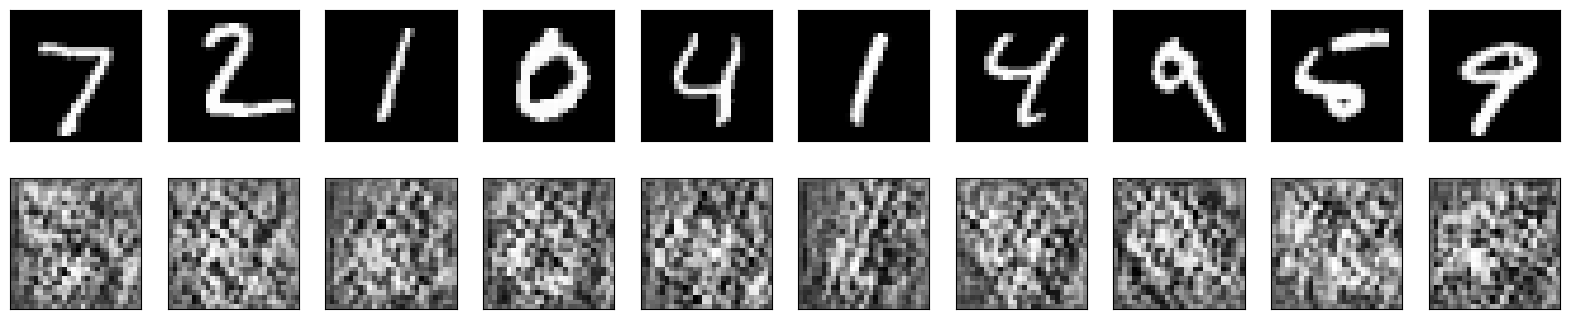

In [55]:
# @title Texto de título predefinido
reconstruction_images_plot(dae,test_loader)